In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/cs4262/EmotionDetection

/content/gdrive/MyDrive/cs4262/EmotionDetection


In [3]:
pip install -r requirements.txt

In [3]:
%cd /content/gdrive/MyDrive/cs4262/EmotionDetection/datasets

/content/gdrive/MyDrive/cs4262/EmotionDetection/datasets


In [5]:
ls -l

total 1803
-rw------- 1 root root     171 Mar  3 00:31 getDataset.sh
-rw------- 1 root root  372902 Mar  3 00:31 test_data.csv
-rw------- 1 root root 1471961 Mar  3 00:31 train_data.csv


In [6]:
!chmod +x getDataset.sh

In [7]:
! bash getDataset.sh

Streaming output truncated to the last 5000 lines.
Extracting  processedDataset/train/sad/Training_10883978_N95.jpg          79%  OK 
Extracting  processedDataset/train/sad/Training_10926620_N95.jpg          79%  OK 
Extracting  processedDataset/train/sad/Training_10963954_N95.jpg          79%  OK 
Extracting  processedDataset/train/sad/Training_10984846_N95.jpg          79%  OK 
Extracting  processedDataset/train/sad/Training_11036409_N95.jpg          79%  OK 
Extracting  processedDataset/train/sad/Training_11080278_N95.jpg          79%  OK 
Extracting  processedDataset/train/sad/Training_11084787_N95.jpg          79%  OK 
Extracting  processedDataset/train/sad/Training_11106902_N95.jpg          79%  OK 
Extracting  processedDataset/train/sad/Training_11108167_N95.jpg          79%  OK 
Extracting  processedDataset/train/sad/Training_11112803_N95.jpg          80%  OK 
Extracting  processedDataset/

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score

# Load training data from CSV
train_df = pd.read_csv("/content/gdrive/MyDrive/cs4262/EmotionDetection/datasets/train_data.csv") # Replace with your own path to train_data.csv

# Load testing data from CSV
test_df = pd.read_csv("/content/gdrive/MyDrive/cs4262/EmotionDetection/datasets/test_data.csv") # Replace with your own path to test_data.csv

# Load images and labels from training data
train_images = []
train_labels = []

for index, row in train_df.iterrows():
    image = load_img(row['trainSet'], target_size=(48, 48))  # Adjust target_size to 48x48
    image = img_to_array(image) / 255.0  # Normalize pixel values
    train_images.append(image)
    train_labels.append(row['trainLabel'])

train_images = np.array(train_images)

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels = to_categorical(train_labels_encoded)  # One-hot encode labels

# Load images and labels from testing data
test_images = []
test_labels = []

for index, row in test_df.iterrows():
    image = load_img(row['testSet'], target_size=(48, 48))  # Adjust target_size to 48x48
    image = img_to_array(image) / 255.0  # Normalize pixel values
    test_images.append(image)
    test_labels.append(row['testabel'])

test_images = np.array(test_images)

# Label encoding for test labels
test_labels_encoded = label_encoder.transform(test_labels)
test_labels = to_categorical(test_labels_encoded)  # One-hot encode labels

# Split training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)



In [ ]:
from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers, callbacks
from sklearn.model_selection import GridSearchCV

# Load MobileNetV2 pre-trained model
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))  # Input shape is set to 48x48

# Freeze the layers of MobileNetV2
for layer in mobilenet_model.layers:
    layer.trainable = False

# Construct your model on top of MobileNetV2
model = models.Sequential([
    mobilenet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),  # Increased capacity
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),  # Increased capacity
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

# Compile the model
initial_learning_rate = 0.001  # Initial learning rate
model.compile(optimizer=optimizers.Adam(lr=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,  # New augmentation parameter
    shear_range=0.1,  # New augmentation parameter
    horizontal_flip=True,
)

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Define learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return initial_learning_rate
    elif epoch < 20:
        return initial_learning_rate * 0.1
    else:
        return initial_learning_rate * 0.01

lr_scheduler = callbacks.LearningRateScheduler(lr_schedule)

# Train the model with data augmentation, early stopping, and learning rate scheduling
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64, shuffle=True),
                    steps_per_epoch=len(train_images) // 64,
                    epochs=100,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

# Fine-tuning
# Unfreeze some layers for fine-tuning
for layer in mobilenet_model.layers[:-20]:  # Unfreeze all layers except the last 20
    layer.trainable = True

# Compile the model again after unfreezing layers
model.compile(optimizer=optimizers.Adam(lr=0.0001),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with fine-tuning
history_finetuned = model.fit(datagen.flow(train_images, train_labels, batch_size=64, shuffle=True),
                              steps_per_epoch=len(train_images) // 64,
                              epochs=100,
                              validation_data=(val_images, val_labels),
                              callbacks=[early_stopping, lr_scheduler])



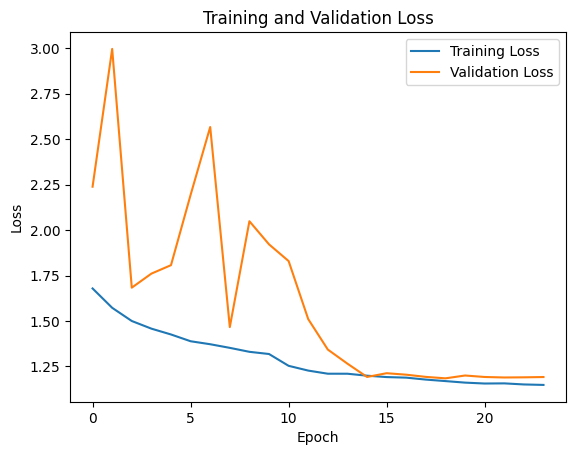

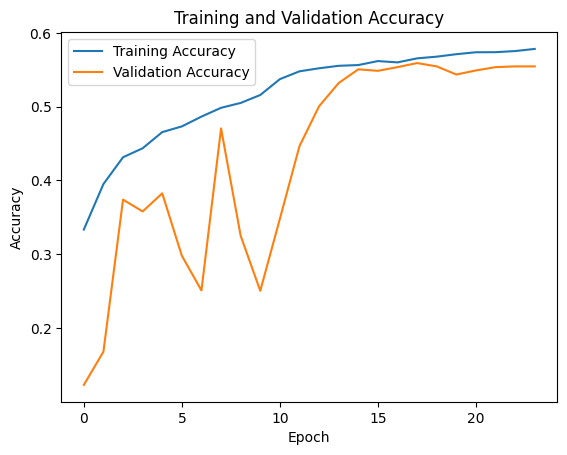

In [15]:
# Plot the loss curves
plt.plot(history_finetuned.history['loss'], label='Training Loss')
plt.plot(history_finetuned.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.plot(history_finetuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetuned.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import f1_score, recall_score

# Make predictions on test data
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Compute F1 score
f1 = f1_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')

# Compute recall
recall = recall_score(np.argmax(test_labels, axis=1), predicted_labels, average='weighted')

print(f'F1 score: {f1}')
print(f'Recall: {recall}')


156/156 [==============================] - 2s 11ms/step
F1 score: 0.5112368542950253
Recall: 0.5425231761386538


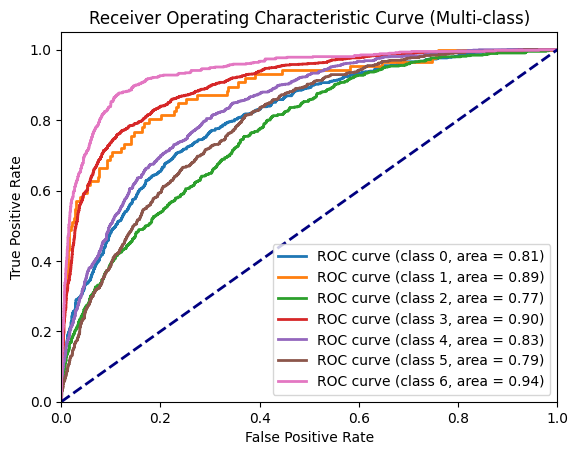

In [22]:
from sklearn.preprocessing import label_binarize

# Convert test labels to binary format
binary_test_labels = label_binarize(np.argmax(test_labels, axis=1), classes=np.arange(predictions.shape[1]))

# Compute ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(predictions.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(binary_test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(predictions.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (Multi-class)')
plt.legend(loc="lower right")
plt.show()


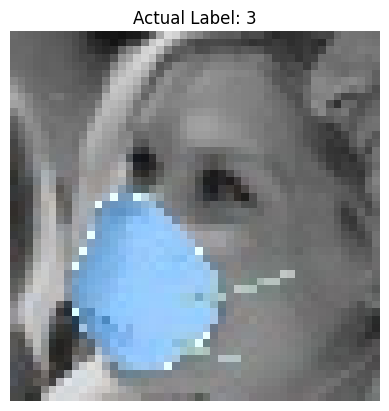

1/1 [==============================] - 0s 37ms/step
Predicted Label: Happy, Confidence: 0.910521388053894


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Generate a random index to select a random image from the test dataset
image_index = random.randint(0, len(test_images) - 1)

# Selected the random image and its corresponding label
selected_image = test_images[image_index]
selected_label = np.argmax(test_labels[image_index])

# Display the random image
plt.imshow(selected_image)
plt.axis('off')
plt.title(f'Actual Label: {selected_label}')
plt.show()

# Make a prediction on the selected image
prediction = model.predict(np.expand_dims(selected_image, axis=0))
predicted_label = np.argmax(prediction)
confidence = np.max(prediction)

# Mapping from label indices to class names
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral',
               'Sad', 'Surprise']

# Display the model's prediction with the name of the emotion
print(f"Predicted Label: {class_names[predicted_label]}, Confidence: {confidence}")
